## Change Log
- Experiments can be setup by using the config parameter "experiment_variable" and assigning the experiment values as a list
- E.g. 
    - experiment_variable = "train_val_split"
    - config["training"]["train_val_split"] = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
- note: only parameters of the category "training" and "model_param" can be used

In [44]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import math

import sys
import os
sys.path.append(os.getcwd() + "/pytorch_tabnet/")

from sklearn.cluster import DBSCAN
from scipy.special import rel_entr

## 0. Experiment Setup

In [46]:
# should an output folder be created to save the experiment data?
save_output = True
save_models = False

In [47]:
# read config file
import toml
config = toml.load("config.toml")

experiment_variable_values = ""
experiment_dict_key = ""
for category_name, category_values in config.items():
    if config["general"]["experiment_variable"] in category_values:
        experiment_variable_values = category_values[config["general"]["experiment_variable"]]
        experiment_dict_key = category_name
        
# rnd seed to support reproducable results
seed_value =  config["general"]["random_seed"] if config["general"]["random_seed"] else random.randrange(2**32 -1)
random.seed(seed_value)
np.random.seed(seed_value)

# TabNet hyperparameters
experiment_variable = config["general"]["experiment_variable"]
regressor_param = {"optimizer_fn" : torch.optim.Adam,
                   "optimizer_params" : {"lr":0.05},
                   "scheduler_params" : {"step_size": 2, "gamma": 0.9},
                   "scheduler_fn" : torch.optim.lr_scheduler.StepLR,
                   "mask_type" : 'entmax',
                   "device_name" : 'cuda', # only working on NVIDIA GPUs
                   "verbose" : 0
                  }

if save_output:
    # create experiment folder
    from datetime import datetime
    
    experiment_name = config["general"]["experiment_name"]
    experiment_folder = f"{experiment_name} {datetime.now().strftime('%Y_%m_%d %H-%M-%S')}" if experiment_name else f"{config['RQ2']['runs']}_runs_{config['general']['experiment_variable']} {datetime.now().strftime('%Y_%m_%d %H-%M-%S')}"
    
    experiment_path = os.path.join("Experiments", experiment_folder)
    os.mkdir(experiment_path)
    
    plots_path = os.path.join(experiment_path, "plots")
    os.mkdir(plots_path)
    
    models_path = os.path.join(experiment_path, "models")
    os.mkdir(models_path)
    
    # save config file
    import shutil
    shutil.copy2("config.toml", experiment_path)
    
    # save random seed
    if not config["general"]["random_seed"]:
        config["general"]["random_seed"] = seed_value
        config_path = os.path.join(experiment_path, "config.toml")
        with open(config_path, "w") as f:
            toml.dump(config, f)
    
    # save model hyperparameters
    with open(os.path.join(experiment_path, 'config.toml'), 'a') as config_file:
        config_file.write("\n#[regressor_param]\n")
        for key, value in regressor_param.items(): 
            config_file.write('#%s = %s\n' % (key, str(value)))
    
    # save notebook
    shutil.copy2(nb_name, experiment_path)
    
    # create output file
    output_path = os.path.join(experiment_path, "output.toml")
    output_file = open(output_path, "w")
    output = {}

## 1. Datasets

Different datasets are to be used for the experiments.
- toy dataset using make_blobs from sklearn mainly to setup and test the notebook
- DAMI Benchmark datasets with the respective best practice hyperparameters (https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/)

### 1.0. Create toy dataset
As of now, only a toy dataset is used (n_features features with clusters centered around different points).

In [48]:
from sklearn.datasets import make_blobs

if config["general"]["use_toy_data"]:
    features_arr, clusters_arr = make_blobs(**config["toy_data"], random_state=seed_value)

    # name feature and cluster (ground truth) columns
    features = pd.DataFrame(features_arr, columns=[f"F{x + 1}" for x in range(features_arr.shape[1])])
    clusters = pd.DataFrame(clusters_arr, columns=["C"])

<IPython.core.display.Javascript object>


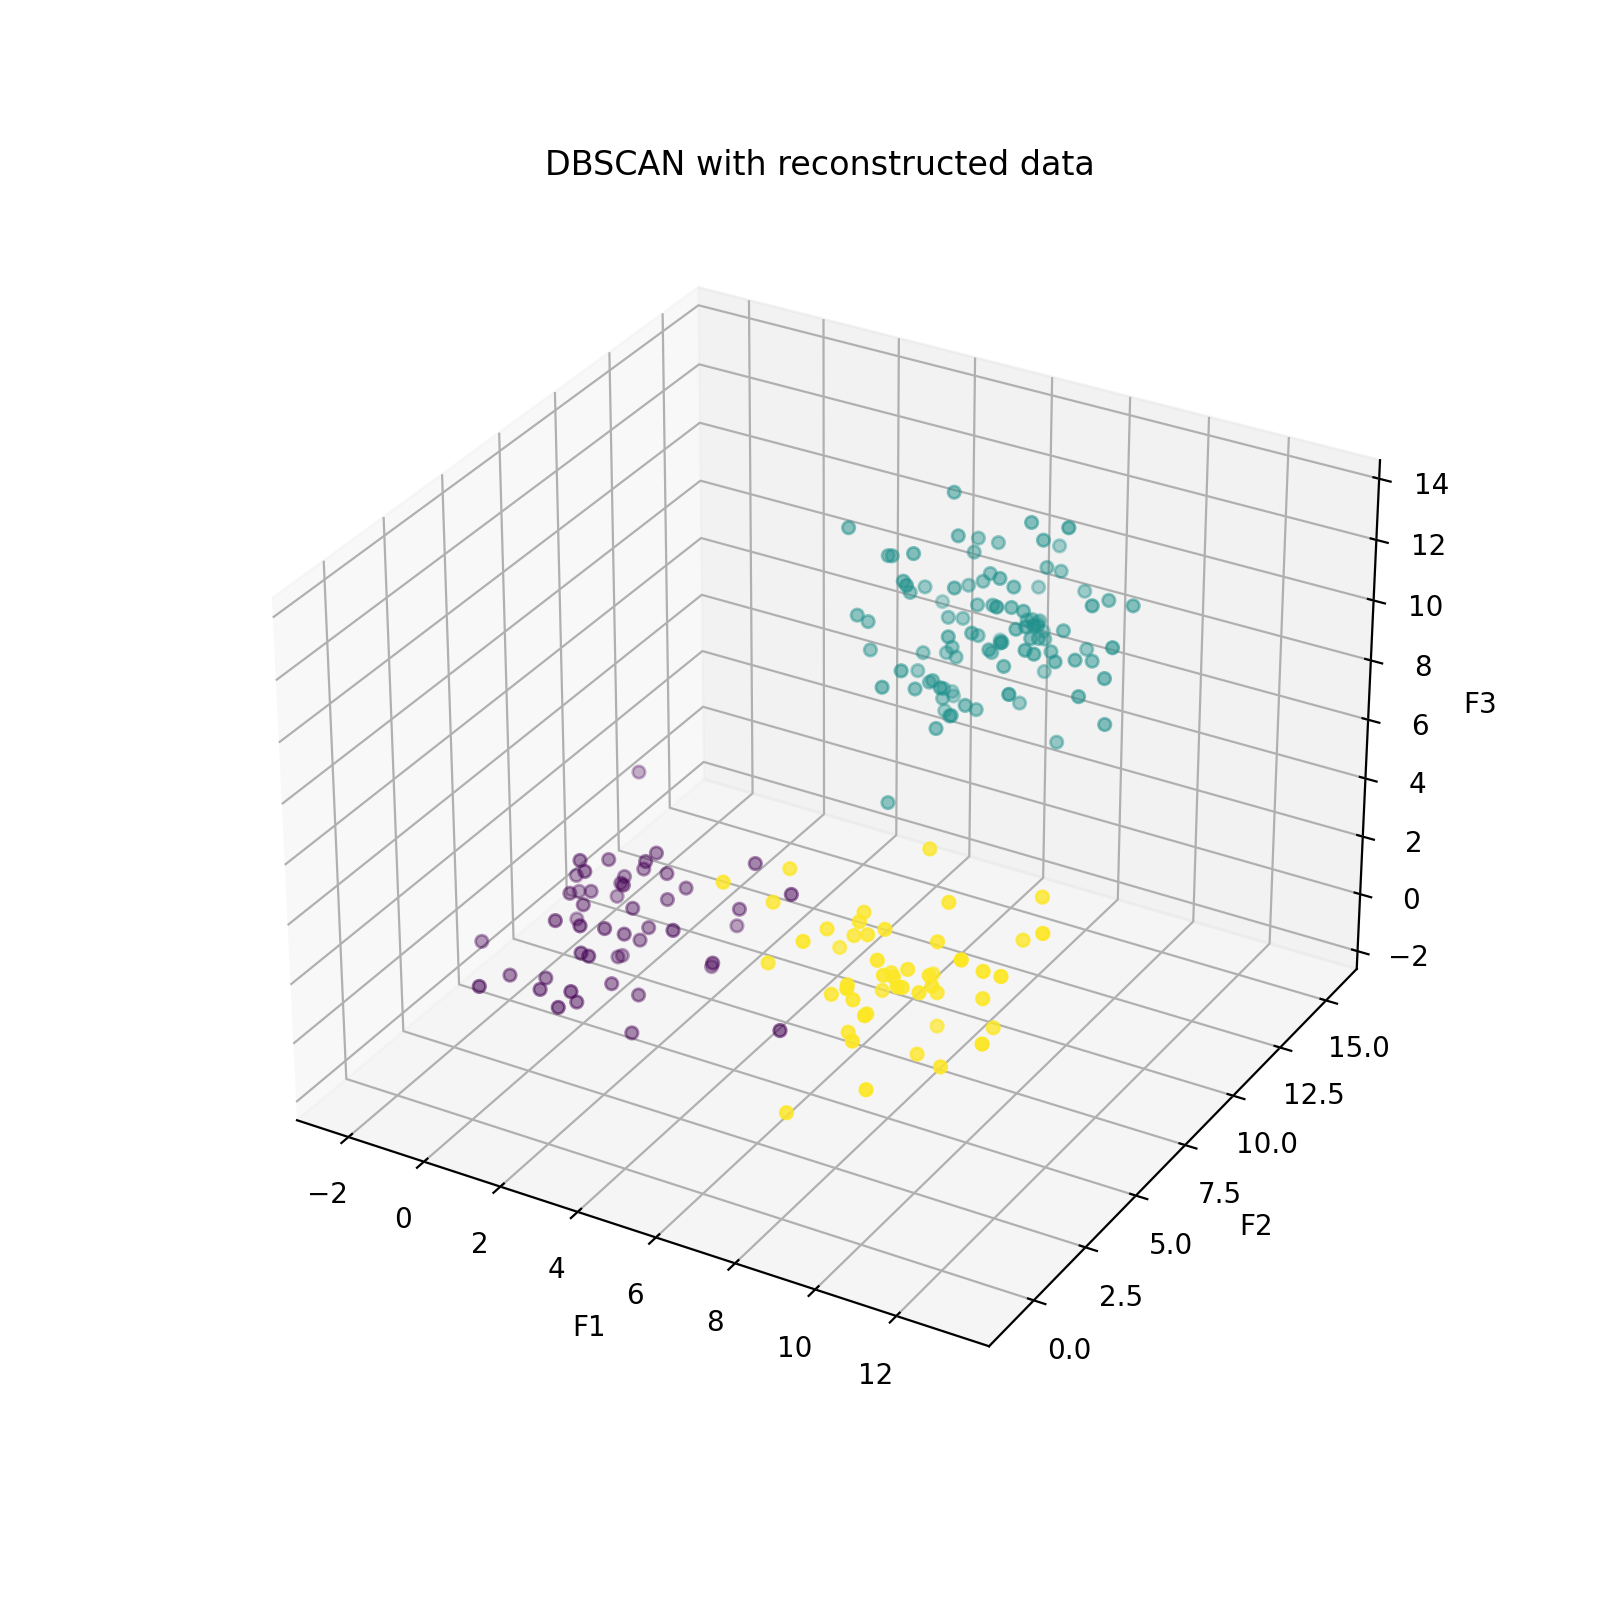

In [49]:
# plot dataset
if config["general"]["use_toy_data"]:
    %matplotlib notebook
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(features_arr[:, 0], features_arr[:, 1], features_arr[:, 2], c=clusters_arr)
    plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
    plt.show()
    if save_output:
        plt.savefig(os.path.join(plots_path, "0_ground_truth_clusters.png"), **config["plots"])

### 1.1. Use existing datasets

In [31]:
if not config["general"]["use_toy_data"]:
    features = pd.read_csv(os.path.join('Datasets', 'housing.csv'))

### 1.2. Create missing data
Create a specified amount of missing values in the given feature columns (for complete datasets).

In [52]:
# create missing values in feature column(s)
mv_config = {feature:mv_ratio for feature,mv_ratio in zip(list(features.columns), config["general"]["missing_percent"])}
features_mv = features.copy()

for f, mv in mv_config.items():
    features_mv[f] = features_mv[f].mask(np.random.random(features.shape[0]) < mv)

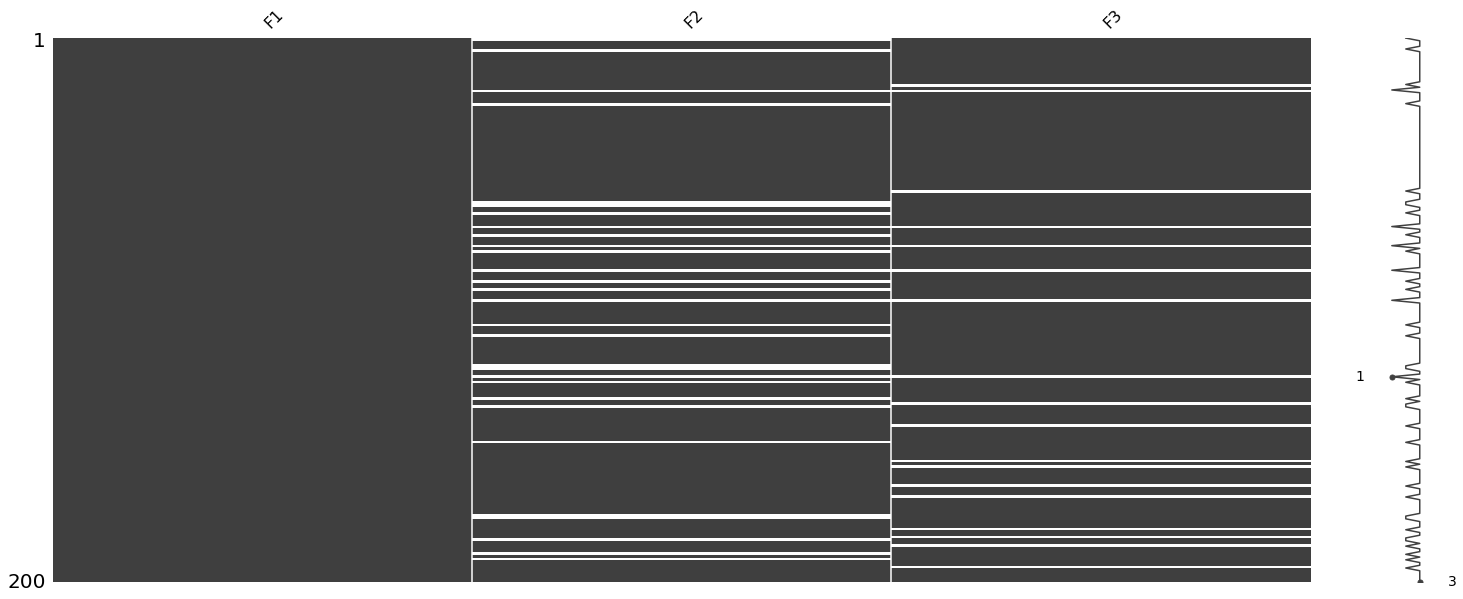

In [53]:
import missingno as msno
%matplotlib inline

# plot missing values
fig = msno.matrix(features_mv)
plt.show()
if save_output:
    #plt.savefig(os.path.join(plots_path, "missing_values.png"), **config["plots"])
    fig_copy = fig.get_figure()
    fig_copy.savefig(os.path.join(plots_path, "missing_values.png"), **config["plots"], bbox_inches = 'tight')

### 1.3. Initial Clustering (without missing values)
Use the cluster algorithm on dataset without missing values.\
Get cluster means for loss function input.

In [34]:
# run DBSCAN on original data
dbscan_orig = DBSCAN(**config["DBSCAN"]).fit(features)
clusters_orig = dbscan_orig.labels_

<IPython.core.display.Javascript object>


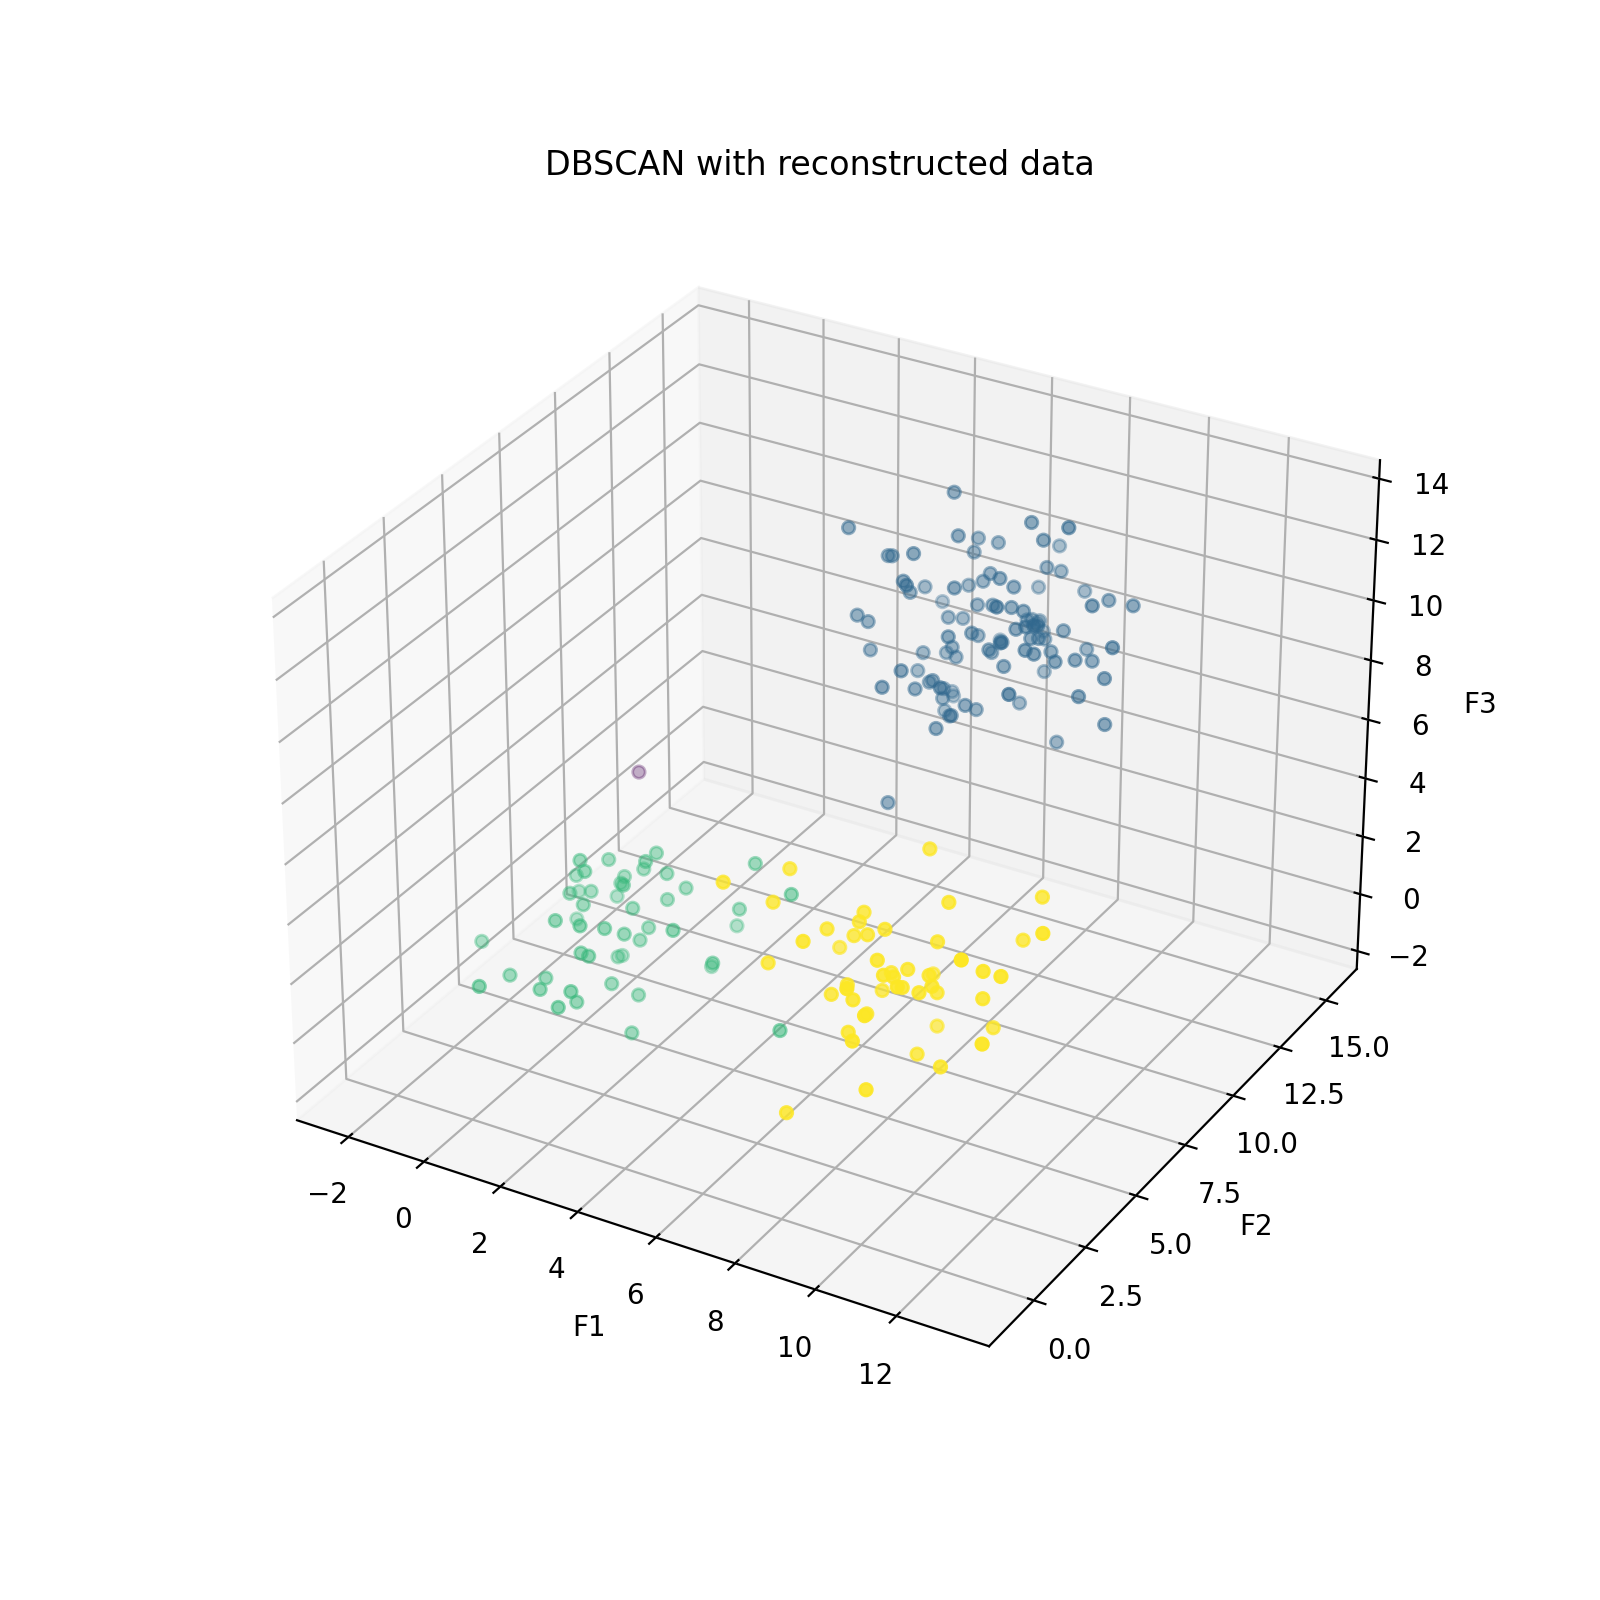

In [35]:
# plot clustering
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features.iloc[:, 0], features.iloc[:, 1], features.iloc[:, 2], c=clusters_orig)
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "1_DBSCAN_original_data.png"), **config["plots"])

In [13]:
# get cluster means (used to calculate the cluster mean loss)
complete_data = features.copy()
complete_data["C"] = clusters_orig
cluster_means = complete_data.groupby("C").agg("mean")
cluster_means = cluster_means if -1 not in cluster_means.index else cluster_means.drop(-1)

## 2. Filling Strategies


### 2.1. Define custom-loss
The loss function for the model fitting shall be customized to improve cluster perforamnce. The custom loss is divided into 2 separate losses

1. **Reconstruction Loss**\
Classic loss function, such as RMSE.
2. **Cluster-Mean Loss**\
The distance to the nearest cluster mean shall be minimized.
3. **KL Divergence Loss**\
Deviation of original distribution shall be minimized \
(prob distribution based on https://stackoverflow.com/questions/57687458/how-to-calculate-probabilities-using-numpy-histogram-and-then-use-it-for-calcula \
number of bins: D. Freedman & P. Diaconis (1981) “On the histogram as a density estimator: L2 theory”. Probability Theory and Related Fields 57 (4): 453-476)

The chosen approach to implement the cluster-mean loss is as follows:\
**Adapt the loss function** to calculate a distance to each cluster. The minimum distance (to the nearest cluster) will be used as a cluster-mean-loss. Minimizing this loss should result in the data point moving closer to the nearest cluster mean.\
Potential Problem: loss functions currently work with y_true (true values) and y_score (predicted values). Calculating the distance would require all features. Calculating only the 1 dimensional distance will result in missing values being put into wrong clusters - depending on the first estimate.

In [14]:
# define custom loss function: extend L2-loss by cluster-mean-loss

from pytorch_tabnet.metrics import Metric
from sklearn.metrics import mean_squared_error
import astropy.stats

class custom_loss(Metric):

    def __init__(self):
        self._name = "custom_loss"
        self._maximize = False

    def __call__(self, y_true, y_score, cluster_means, target_feature, x_val, y_val):
        # reconstruction loss
        rmse = np.sqrt(mean_squared_error(y_true, y_score))
        
        # cluster mean loss
        cml = self.cluster_mean_loss(cluster_means, y_score, target_feature, x_val, y_val)
        
        # KL divergence loss
        bins = len(astropy.stats.freedman_bin_width(y_true.reshape(1,-1)[0], return_bins=True)[1])
        distr1, distr2 = self.probability_dist(y_score, y_true, bins)
        KLdl = torch.nn.functional.kl_div(torch.tensor(distr1).log(), torch.tensor(distr2), log_target=False, reduction='sum').item()
        
        # total loss
        custom_loss = rmse + KLdl + cml
        return custom_loss
    
    # calculate sum of distances to the closest cluster mean
    def cluster_mean_loss(self, cluster_means, y_score, target_feature, x_val, y_val):
        
        # reorder cluster_means to match x_val columns (predicted feature is last column)
        cols = cluster_means.columns.tolist()
        feature_col = features.columns.get_loc(target_feature)
        cols = cols[:feature_col] + cols[feature_col+1:] + [target_feature]
        
        # x values extended by predicted values
        x_extended = pd.DataFrame(np.hstack((x_val, y_score)), columns=cols)


        # calculate distances to each cluster and select the closest one
        dist = []
        for cluster in range(cluster_means.shape[0]):
            dist.append(np.linalg.norm((x_extended - cluster_means.iloc[cluster]), axis=1))
            
        dist = pd.DataFrame(dist).T
        min_dist = dist.assign(min_dist=lambda d: d.min(1))["min_dist"]
        
        return sum(min_dist)
    
    # calculate probabilities
    def probability_dist(self, x, y, bins):
        # transforms 2 series into their probability distributions
        # histogram
        hist_xy = np.histogram2d(np.asarray(x)[:,0], np.asarray(y)[:,0], bins=bins)[0]

        # compute marginals
        hist_xy = hist_xy + sys.float_info.min # prevent division with 0
        hist_xy = hist_xy / np.sum(hist_xy)
        hist_x = np.sum(hist_xy, axis=1)
        hist_y = np.sum(hist_xy, axis=0)
        return(hist_x, hist_y)

### 2.2. Fill missing values (TabNet).

**Approach 1:**\
For each feature that contains missing values, use all rows with complete other features as train set and predict missing values of the feature.\
&rarr; Problem: lots of models, especially for high-dimensional datasets. 
Also problem, if more than one feature is missing values. &rarr; see Approach 2

**Approach 2:**\
Mask missing values as -1 (or some other value) and fit a model predicting each feature just like in approach 1.\
&rarr; one model for each feature containing missing values.\
Possible adaption: use predicted values to predict subsequent values (instead of using -1)

In [15]:
import time

from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split

features_to_predict = features_mv.columns[features_mv.isnull().any()]
features_reconstr = {}
costs = {}
output["runtimes"] = {}

for run in range(config["RQ2"]["runs"]):
    
    print(f"Run {run + 1} / {config['RQ2']['runs']}")
    features_reconstr[run] = []
    costs[run] = {}
    output["runtimes"][f"run_{run}"] = {}
    
    for i, experiment_value in enumerate(experiment_variable_values):
        
        config[experiment_dict_key][config["general"]["experiment_variable"]] = experiment_value
        
        time_start = time.time()
        features_reconstr[run].append(features_mv.copy())
        costs[run][str(experiment_value)] = []

        for feature in features_to_predict:
            
            # select % of features for prediction based on pred_features (e.g. 10% of randomly selected features)
            number_of_features = math.ceil(config["RQ2"]["pred_features"] * (len(features_mv.columns)) - 1)
            features_mv_masked = features_mv.copy().drop(feature, axis=1).sample(n=number_of_features, axis='columns')
            selected_features = features_mv_masked.columns

            # mask other columns' missing values as defined in config (missing_value_mask)
            features_mv_masked[feature] = features_mv[feature]
            features_mv_masked[selected_features] = features_mv_masked[(selected_features)].fillna(config["general"]["missing_value_mask"])

            # separate complete rows as train data
            # separate column with missing values as target
            test_data = features_mv_masked[features_mv_masked[feature].isna()].drop(feature, axis=1).to_numpy()
            train_data = features_mv_masked[features_mv_masked[feature].notna()]
            train_features = train_data.drop(columns=feature).to_numpy()
            train_target = train_data[feature].to_numpy().reshape(-1,1)

            x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, train_size=config["training"]["train_val_split"])

            # create & train model
            model = TabNetRegressor(**regressor_param)
            model.fit(
                x_train, y_train,
                eval_set=[(x_val, y_val)],
                **config["model_param"],
                cluster_means=cluster_means,
                target_feature=feature,
                x_val=x_val,
                y_val=y_val,
            )

            #track runtime
            time_end = time.time()

            # add costs to dict
            costs[run][str(experiment_value)].append(model.best_cost)


            # fill missing values with model predictions
            features_reconstr[run][i].loc[features_reconstr[run][i][feature].isna(), feature] = [x[0] for x in model.predict(test_data)]

            # save outputs
            if save_models:

                # save model
                torch.save(model, os.path.join(models_path, f"Model_run{run}_{config['general']['experiment_variable']}{experiment_value}_{feature}.pt"))
            
            if save_output:
                # save runtimes
                output["runtimes"][f"run_{run}"][f"{config['general']['experiment_variable']}_{feature}"] = time_end - time_start


Run 1 / 100
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.45562
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 159 and best_val_0_custom_loss = 2.19975
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.29866
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.38031
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.27466
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.9617
Best weights from best epoch are automatically used!
Stop traini


Early stopping occurred at epoch 168 with best_epoch = 118 and best_val_0_custom_loss = 2.82873
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.43376
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 156 and best_val_0_custom_loss = 2.2384
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.00756
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.2186
Best weights from best epoch are automatically used!
Run 5 / 100
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.70967
Best weights from best epoch are automatically used!

Early stopping occurred 

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.55402
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 178 and best_val_0_custom_loss = 3.39368
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.84635
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.18827
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.00305
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.82363
Best weights from best epoch are automatically used!
Stop training because 

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.11645
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 199 with best_epoch = 149 and best_val_0_custom_loss = 2.23287
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.91776
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.20947
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 13 and best_val_0_custom_loss = 8.05637
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.05587
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.00515
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.28236
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 159 and best_val_0_custom_loss = 2.25172
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.46289
Best weights from best epoch are automatically used!
Run 16 / 100

Early stopping occurred at epoch 128 with best_epoch = 78 and best_val_0_custom_loss = 3.79434
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.87247
Best weights from best epoch are automatically used!

Early stopping occurre

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.49188
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 185 and best_val_0_custom_loss = 2.22548
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.11949
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.62915
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 198 and best_val_0_custom_loss = 2.1484
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.73676
Best weights from best epoch are automatically used!
Stop training because y

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.01499
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.55385
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 165 and best_val_0_custom_loss = 3.80637
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.26879
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 94 with best_epoch = 44 and best_val_0_custom_loss = 4.36273
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 195 and best_val_0_custom_loss = 1.6869
Best weights from best epoch are automatically used!
Stop training because you reached max_

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.76452
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 34 and best_val_0_custom_loss = 3.86724
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.03206
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 46 and best_val_0_custom_loss = 4.67523
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.72203
Best weights from best epoch are automatically used!
Run 27 / 100
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.34866
Best weights from best epoch are automatically used!
Stop training because you reached max_e


Early stopping occurred at epoch 174 with best_epoch = 124 and best_val_0_custom_loss = 4.22388
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.03146
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.05667
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.08597
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 194 and best_val_0_custom_loss = 2.4424
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.0363
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 198


Early stopping occurred at epoch 109 with best_epoch = 59 and best_val_0_custom_loss = 4.48417
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.47224
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 194 and best_val_0_custom_loss = 2.66532
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 191 and best_val_0_custom_loss = 2.37551
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.70698
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.09504
Best weights from best epoch are automatically used!
Stop training because you reached ma

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.11719
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.34663
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.78741
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.51876
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 198 and best_val_0_custom_loss = 1.90613
Best weights from best epoch are automatically used!
Run 38 / 100
Stop training because you reached max_epochs = 200 with best_epoch = 170 and best_val_0_custom_loss = 6.71893
Best weights from best epoch are automatically used!
Stop trai

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.03203
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.87002
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 115 with best_epoch = 65 and best_val_0_custom_loss = 4.37905
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.26763
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.91088
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 191 with best_epoch = 141 and best_val_0_custom_loss = 1.69116
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 20

Stop training because you reached max_epochs = 200 with best_epoch = 194 and best_val_0_custom_loss = 2.33801
Best weights from best epoch are automatically used!
Run 45 / 100

Early stopping occurred at epoch 87 with best_epoch = 37 and best_val_0_custom_loss = 5.3742
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 105 with best_epoch = 55 and best_val_0_custom_loss = 2.78824
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 5.14401
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 155 and best_val_0_custom_loss = 2.17412
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.37541
Best weights from best epoch are automatically used!
Stop training because you reached max_e

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.01249
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 149 with best_epoch = 99 and best_val_0_custom_loss = 3.5824
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 169 and best_val_0_custom_loss = 1.67684
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.93562
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.13596
Best weights from best epoch are automatically used!
Run 49 / 100
Stop training because you reached max_epochs = 200 with best_epoch = 189 and best_val_0_custom_loss = 2.77703
Best weights from best epoch are automatically used!
Stop training because yo

Stop training because you reached max_epochs = 200 with best_epoch = 187 and best_val_0_custom_loss = 3.35796
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.20178
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 164 and best_val_0_custom_loss = 3.15101
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.76667
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 38 and best_val_0_custom_loss = 3.10737
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.94367
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 102

Stop training because you reached max_epochs = 200 with best_epoch = 186 and best_val_0_custom_loss = 1.74023
Best weights from best epoch are automatically used!
Run 56 / 100
Stop training because you reached max_epochs = 200 with best_epoch = 192 and best_val_0_custom_loss = 2.20098
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 163 and best_val_0_custom_loss = 1.80231
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 4.08667
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.34702
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 166 and best_val_0_custom_loss = 4.34476
Best weights from best epoch are automatically used!
Stop trai


Early stopping occurred at epoch 71 with best_epoch = 21 and best_val_0_custom_loss = 3.94325
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.21181
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.25629
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.61871
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.81563
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 170 and best_val_0_custom_loss = 2.51418
Best weights from best epoch are automatically used!
Run 60 / 100

Early stopping occurred

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.26942
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 173 and best_val_0_custom_loss = 2.48404
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.11836
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 155 and best_val_0_custom_loss = 2.4344
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.45955
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.89929
Best weights from best epoch are automatically used!
Stop training because y


Early stopping occurred at epoch 136 with best_epoch = 86 and best_val_0_custom_loss = 2.86565
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 187 and best_val_0_custom_loss = 1.79364
Best weights from best epoch are automatically used!
Run 67 / 100
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.69372
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.16419
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 103 with best_epoch = 53 and best_val_0_custom_loss = 4.23594
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.39237
Best weights from best epoch are automatically used!
Stop training because you reached max

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.86219
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.67858
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.86289
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 4.29335
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.08858
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 194 and best_val_0_custom_loss = 4.72264
Best weights from best epoch are automatically used!
Stop training because 

Stop training because you reached max_epochs = 200 with best_epoch = 162 and best_val_0_custom_loss = 3.97223
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.03708
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.79529
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 169 and best_val_0_custom_loss = 3.04697
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.39998
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 178 and best_val_0_custom_loss = 1.82858
Best weights from best epoch are automatically used!
Stop training because 

Stop training because you reached max_epochs = 200 with best_epoch = 183 and best_val_0_custom_loss = 1.89874
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 195 with best_epoch = 145 and best_val_0_custom_loss = 3.05721
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.67036
Best weights from best epoch are automatically used!
Run 78 / 100
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.38358
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 184 and best_val_0_custom_loss = 2.28709
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.09656
Best weights from best epoch are automatically used!
Stop training because 


Early stopping occurred at epoch 106 with best_epoch = 56 and best_val_0_custom_loss = 4.0558
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 181 and best_val_0_custom_loss = 1.7722
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 179 with best_epoch = 129 and best_val_0_custom_loss = 2.66695
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.1232
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 199 with best_epoch = 149 and best_val_0_custom_loss = 3.17642
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 194 with best_epoch = 144 and best_val_0_custom_loss = 2.03021
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 102 with best_epoch = 52 and best_val_0_cust


Early stopping occurred at epoch 109 with best_epoch = 59 and best_val_0_custom_loss = 3.6417
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.83552
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.9846
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 171 and best_val_0_custom_loss = 2.03711
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 155 with best_epoch = 105 and best_val_0_custom_loss = 2.47764
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.0624
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 w

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.99073
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 164 and best_val_0_custom_loss = 2.8145
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 176 and best_val_0_custom_loss = 3.04974
Best weights from best epoch are automatically used!
Run 89 / 100

Early stopping occurred at epoch 84 with best_epoch = 34 and best_val_0_custom_loss = 4.57153
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.35957
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 171 and best_val_0_custom_loss = 3.12562
Best weights from best epoch are automatically used!

Early stopping occurred 

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.94542
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.53816
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.91165
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 153 and best_val_0_custom_loss = 2.75739
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.15694
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 154 and best_val_0_custom_loss = 1.09919
Best weights from best epoch are automatically used!
Stop training because 

Stop training because you reached max_epochs = 200 with best_epoch = 181 and best_val_0_custom_loss = 3.18499
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 1.99331
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 180 and best_val_0_custom_loss = 3.71251
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.03393
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.23649
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.27769
Best weights from best epoch are automatically used!
Stop training because 

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.19157
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.91619
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.32461
Best weights from best epoch are automatically used!
Run 100 / 100
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 3.1576
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_custom_loss = 2.79529
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 170 and best_val_0_custom_loss = 3.8999
Best weights from best epoch are automatically used!
Stop train

## 3. Complete Dataset
Costs for each run

In [16]:
costs

{0: {'0.6': [3.455624148371224, 2.199753165934193],
  '0.65': [3.2986592321448334, 2.380305551545218],
  '0.7': [3.274657203456031, 1.9616963517378179],
  '0.75': [4.159802812434567, 1.907876160007651],
  '0.8': [3.1814507059146337, 1.9910558564304757],
  '0.85': [4.350383091452642, 1.5832145140623597],
  '0.9': [2.9649028920164775, 1.2165368032898778]},
 1: {'0.6': [3.751293361026593, 2.3056267526393426],
  '0.65': [3.849839576487291, 2.1573518626862644],
  '0.7': [3.718751937743381, 2.614206218096825],
  '0.75': [4.224871598580385, 2.6079507646314384],
  '0.8': [2.8921056498065316, 2.414778223932681],
  '0.85': [5.60192571376135, 1.767422799366937],
  '0.9': [3.4918609106771608, 1.751038484824704]},
 2: {'0.6': [3.352348034666809, 1.9844684139610056],
  '0.65': [3.5559992439004646, 2.0567341548046914],
  '0.7': [4.4972758553239975, 1.9851586350925363],
  '0.75': [6.680136925025099, 2.2403827272498433],
  '0.8': [4.473711380399906, 3.7051946792781085],
  '0.85': [5.71881439203328, 2.0

### 3.1 Reconstruct Dataset
choose best model based on min. squared custom loss (punishing large outliers in losses for single features)

In [69]:
best_per_run = []
best_per_run_index = []
for run in range(config["RQ2"]["runs"]):
    cost_totals = [sum([x**2 for x in c]) for _, c in costs[run].items()]
    best_per_run.append(min(cost_totals))
    best_per_run_index.append(cost_totals.index(min(cost_totals)))
    
best_run = best_per_run.index(min(best_per_run))
best_model = best_per_run_index[best_run]
print(f"Best model: run {best_run} model {best_model}")

features_best = features_reconstr[best_run][best_model]

Best model: run 95 model 5


### 3.2 Plot changes (comp. to original data)

<IPython.core.display.Javascript object>


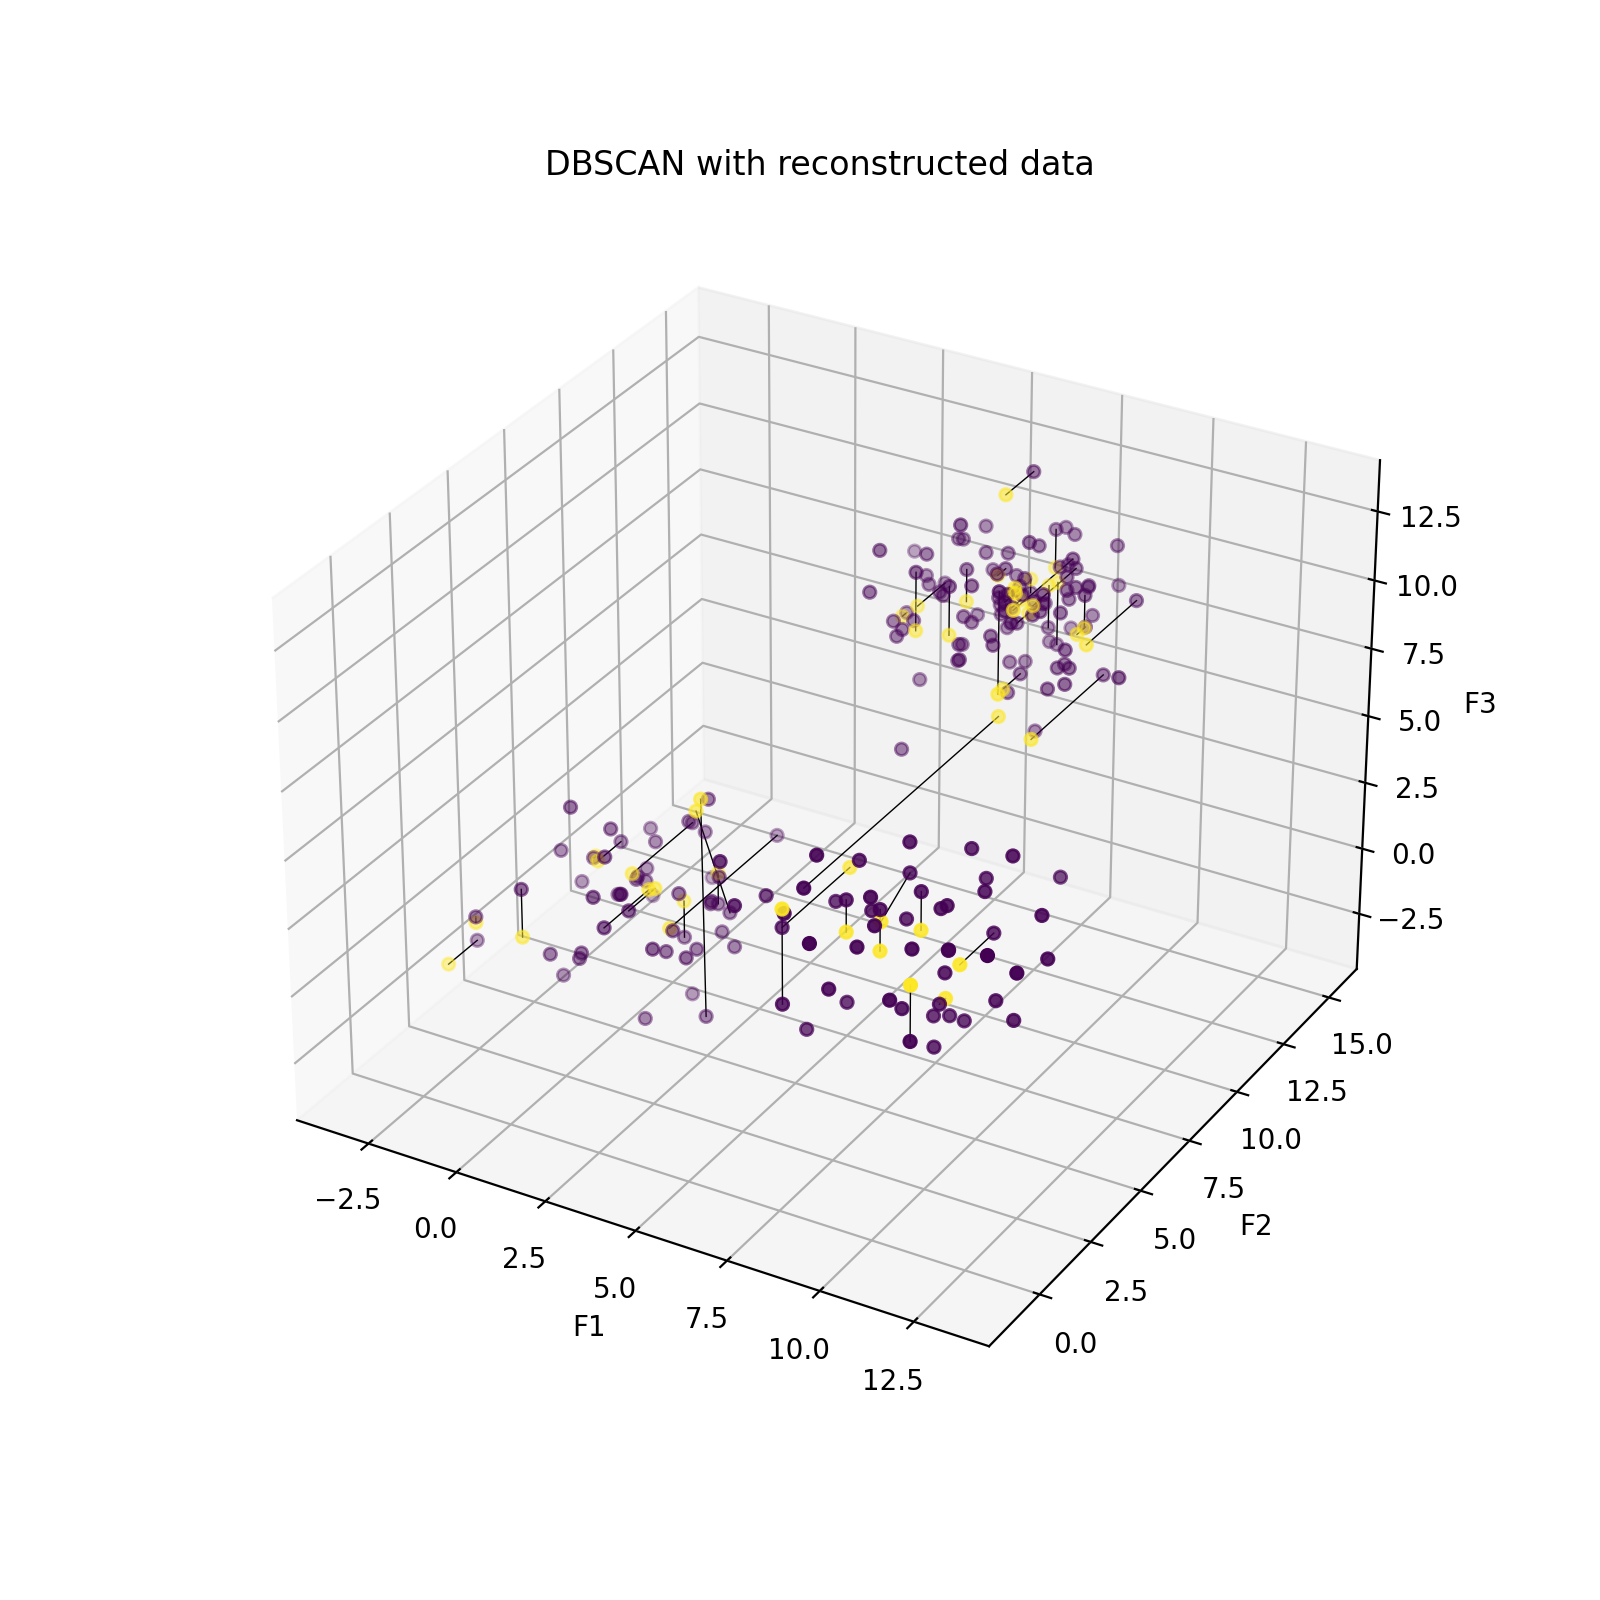

In [70]:
# scatter plot with combined data
orig_data = features.copy()
orig_data["change"] = 0
changed_data = features_best[features_mv.isna().any(axis=1)]
comp_data = pd.concat([orig_data, changed_data]).reset_index(drop=True).fillna(1)

# line plot connecting filled data to true data points
reconstr_data = features_best[features_mv.isna().any(axis=1)]
true_data = features[features_mv.isna().any(axis=1)]

# plot
fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(projection = '3d')
ax.scatter(comp_data["F1"], comp_data["F2"], comp_data["F3"], c=[comp_data["change"]])

for i in range(len(reconstr_data)):
    ax.plot([reconstr_data["F1"].iloc[i], true_data["F1"].iloc[i]],[reconstr_data["F2"].iloc[i], true_data["F2"].iloc[i]],[reconstr_data["F3"].iloc[i], true_data["F3"].iloc[i]], color="black", linewidth=.5)


plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show
if save_output:
    plt.savefig(os.path.join(plots_path, "4_imputation_differences.png"), **config["plots"])

## 4. Clustering

In [40]:
# apply clustering
clusters_reconstr = []
for run in range(config["RQ2"]["runs"]):
    clusters_reconstr.append([])
    for i, var in enumerate(experiment_variable_values):
        dbscan_reconstr = DBSCAN(**config["DBSCAN"]).fit(features_reconstr[run][i])
        clusters_reconstr[run].append(dbscan_reconstr.labels_)

### 4.1. Plot of clustering based on best model predictions

<IPython.core.display.Javascript object>


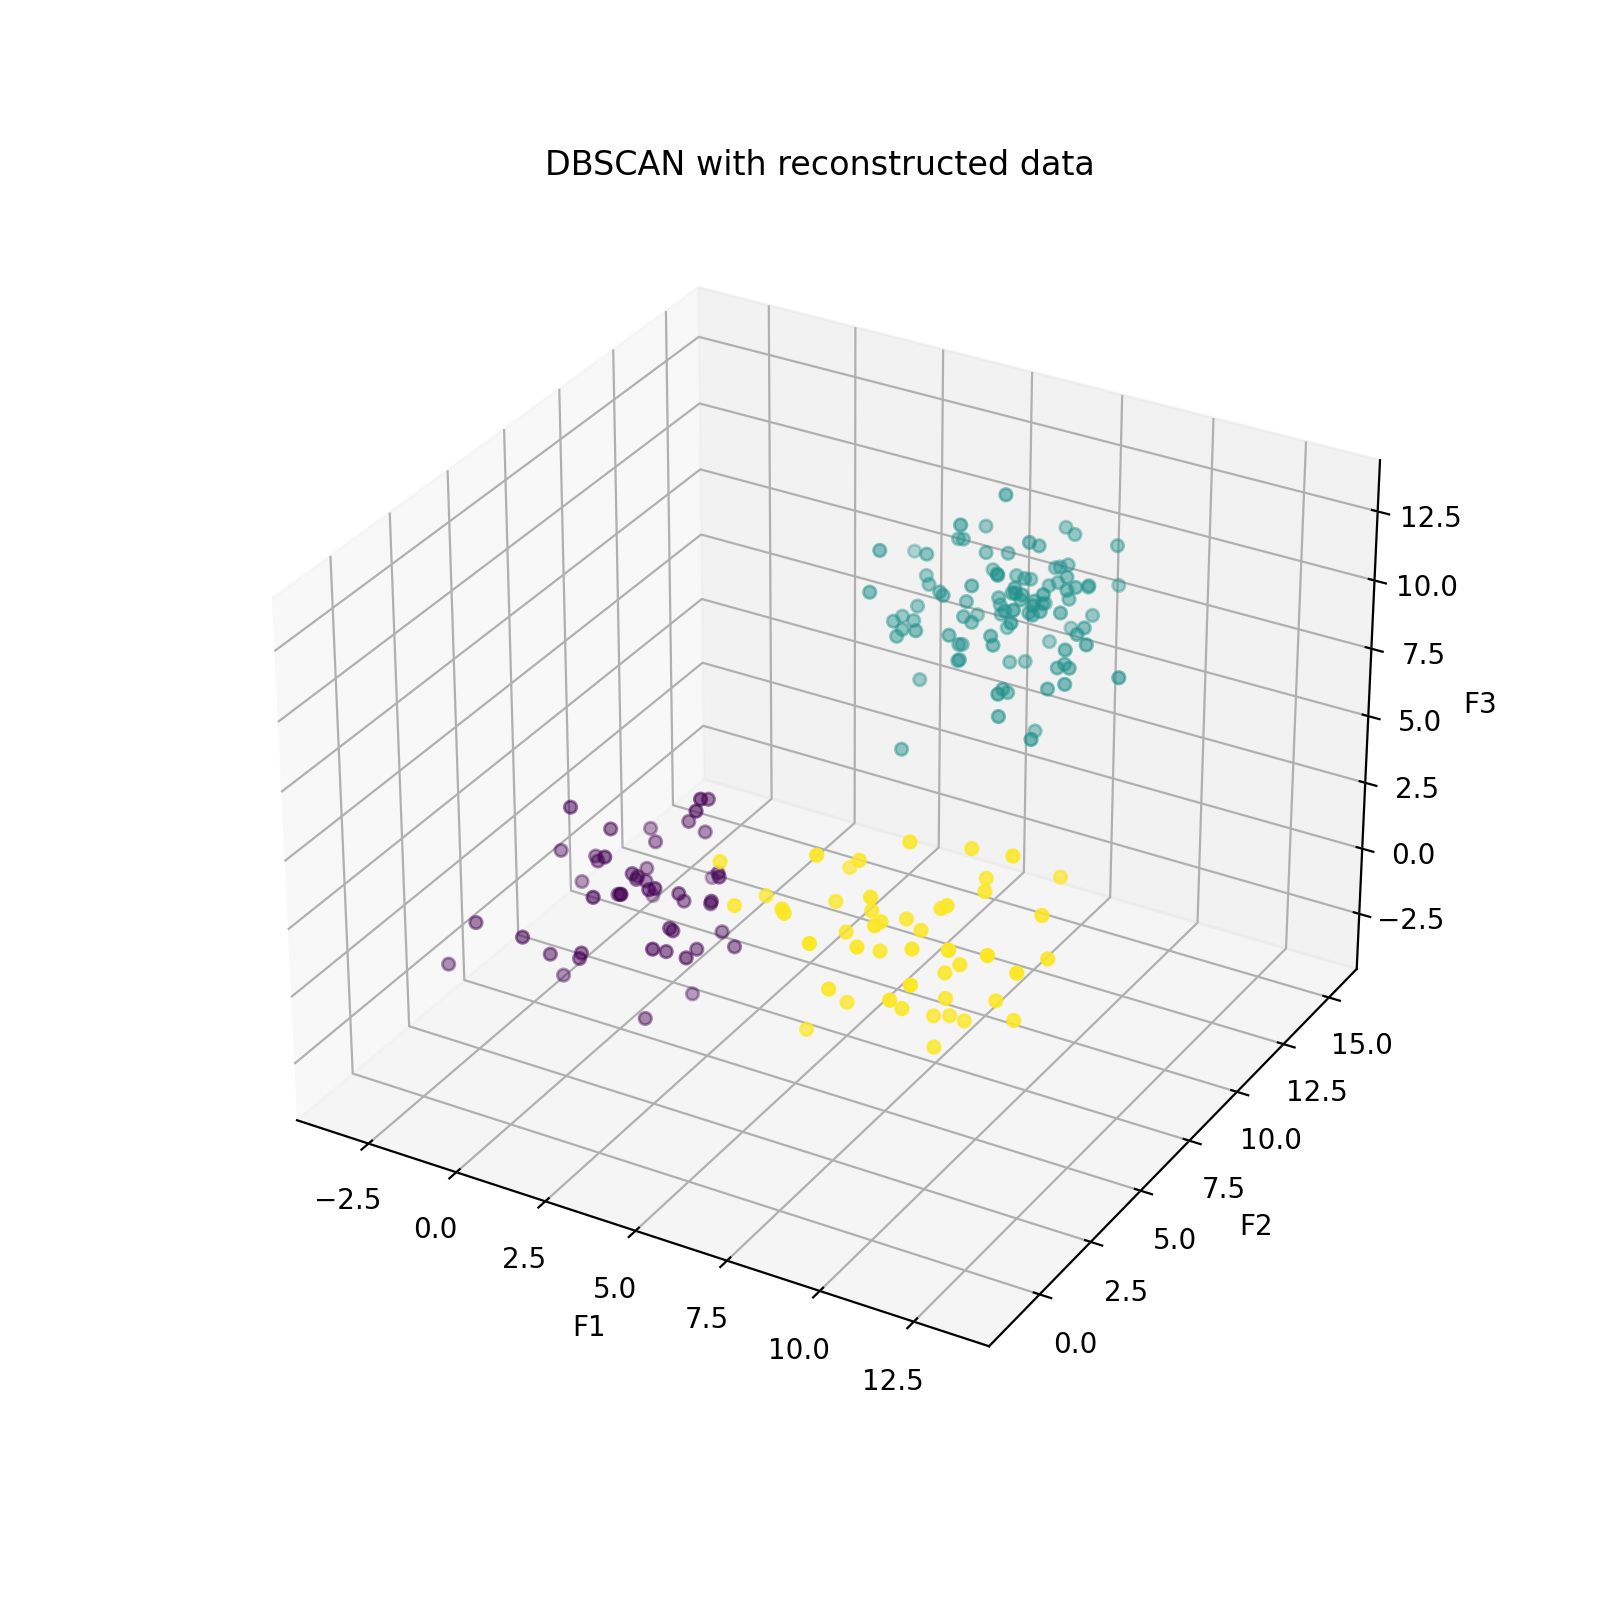

In [41]:
# plot new clustering
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_reconstr[best_run][best_model].iloc[:, 0], features_reconstr[best_run][best_model].iloc[:, 1], features_reconstr[best_run][best_model].iloc[:, 2], c=clusters_reconstr[best_run][best_model])
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "3_DBSCAN_imputed_data.png"), **config["plots"])

## 5. Cluster Performance


### 5.1 Feature Distributions
#### 5.1.1 Distr. Plots based on best model predictions

<IPython.core.display.Javascript object>


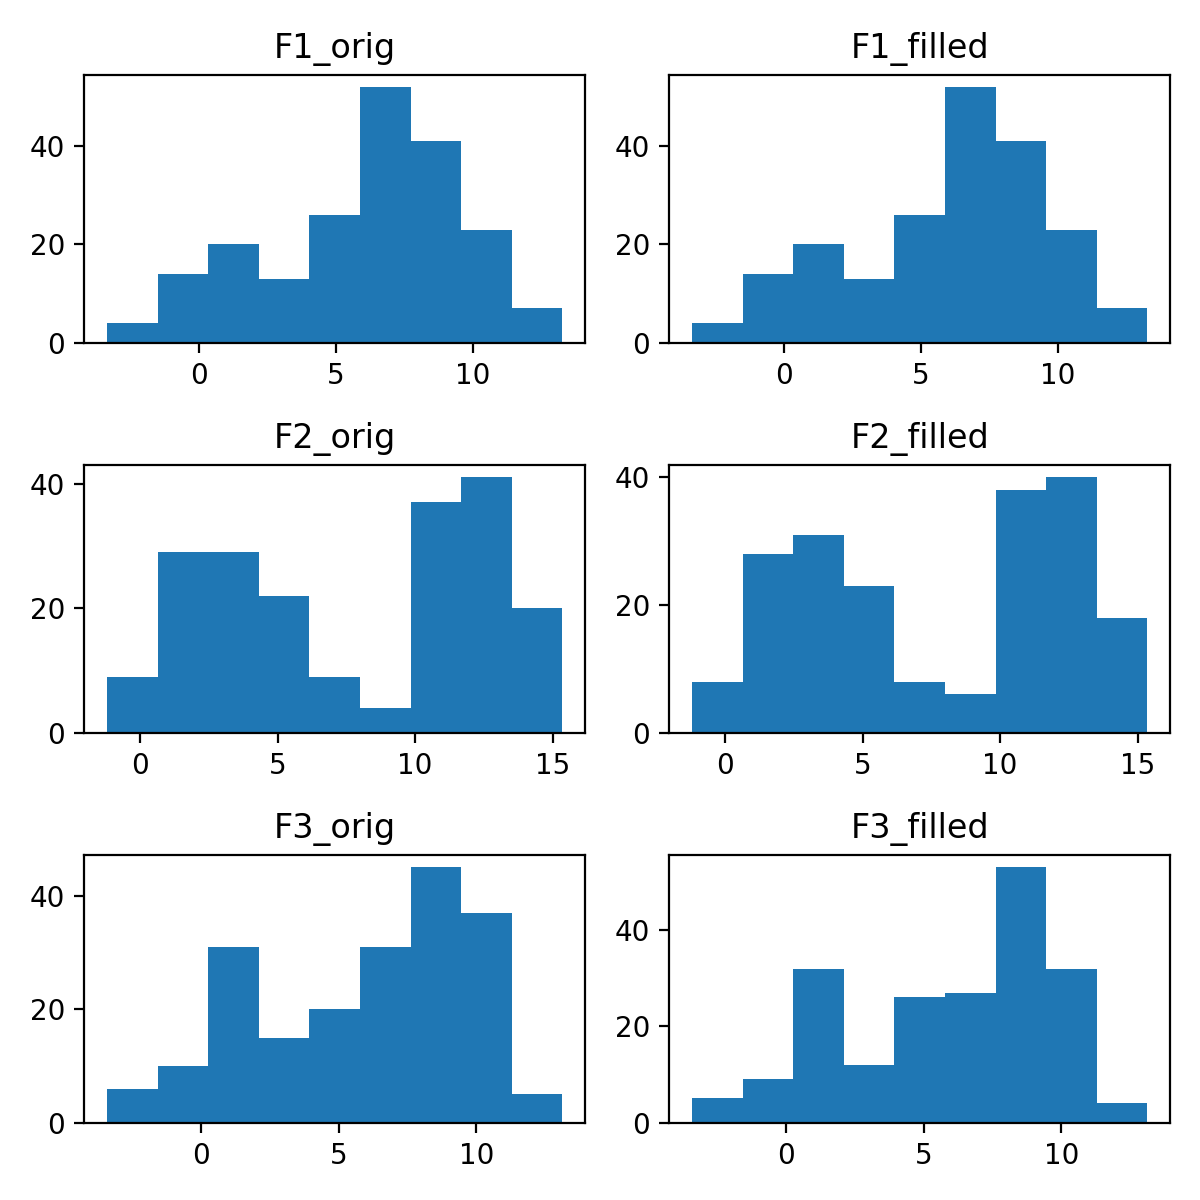

In [21]:
# plot distributions
bins = len(astropy.stats.freedman_bin_width(features[feature], return_bins=True)[1])
n_feat = len(features_best.columns)

fig, (ax) = plt.subplots(n_feat, 2, figsize=(n_feat*2,6))
for n, feature in enumerate(features_best.columns):
    ax[n, 0].hist(features[feature], bins=bins)
    ax[n, 0].set_title(f"{feature}_orig")
    ax[n, 1].hist(features_best[feature], bins=bins)
    ax[n, 1].set_title(f"{feature}_filled")

fig.tight_layout()
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "feature distributions.png"), **config["plots"])

#### 5.1.2 KL Divergence

In [22]:
# KL Divergence
def kl_divergence(feature1, feature2):
    
    # calculate probability distributions
    def probability_dist(x, y, bins):
        # transforms 2 series into their probability distributions
        # histogram
        hist_xy = np.histogram2d(x, y, bins=bins)[0]

        # compute marginals
        hist_xy = hist_xy + sys.float_info.min # prevent division with 0
        hist_xy = hist_xy / np.sum(hist_xy)
        hist_x = np.sum(hist_xy, axis=1)
        hist_y = np.sum(hist_xy, axis=0)
        return(hist_x, hist_y)

    # calculate kl divergence
    bins = len(astropy.stats.freedman_bin_width(feature1, return_bins=True)[1])
    distr1, distr2 = probability_dist(feature1, feature2, bins)
    return torch.nn.functional.kl_div(torch.tensor(distr1).log(), torch.tensor(distr2), log_target=False, reduction='sum').item()

In [23]:
output["kl_divergence"] = {}

# save kl divergence
for run in range(config["RQ2"]["runs"]):
    output["kl_divergence"][f"run_{run}"] = {}
    for i, experiment_value in enumerate(experiment_variable_values):
        output["kl_divergence"][f"run_{run}"][str(experiment_value)] = {}
        for feature in features_to_predict:
            output["kl_divergence"][f"run_{run}"][str(experiment_value)][feature] = kl_divergence(features[feature], features_reconstr[run][i][feature])

<IPython.core.display.Javascript object>


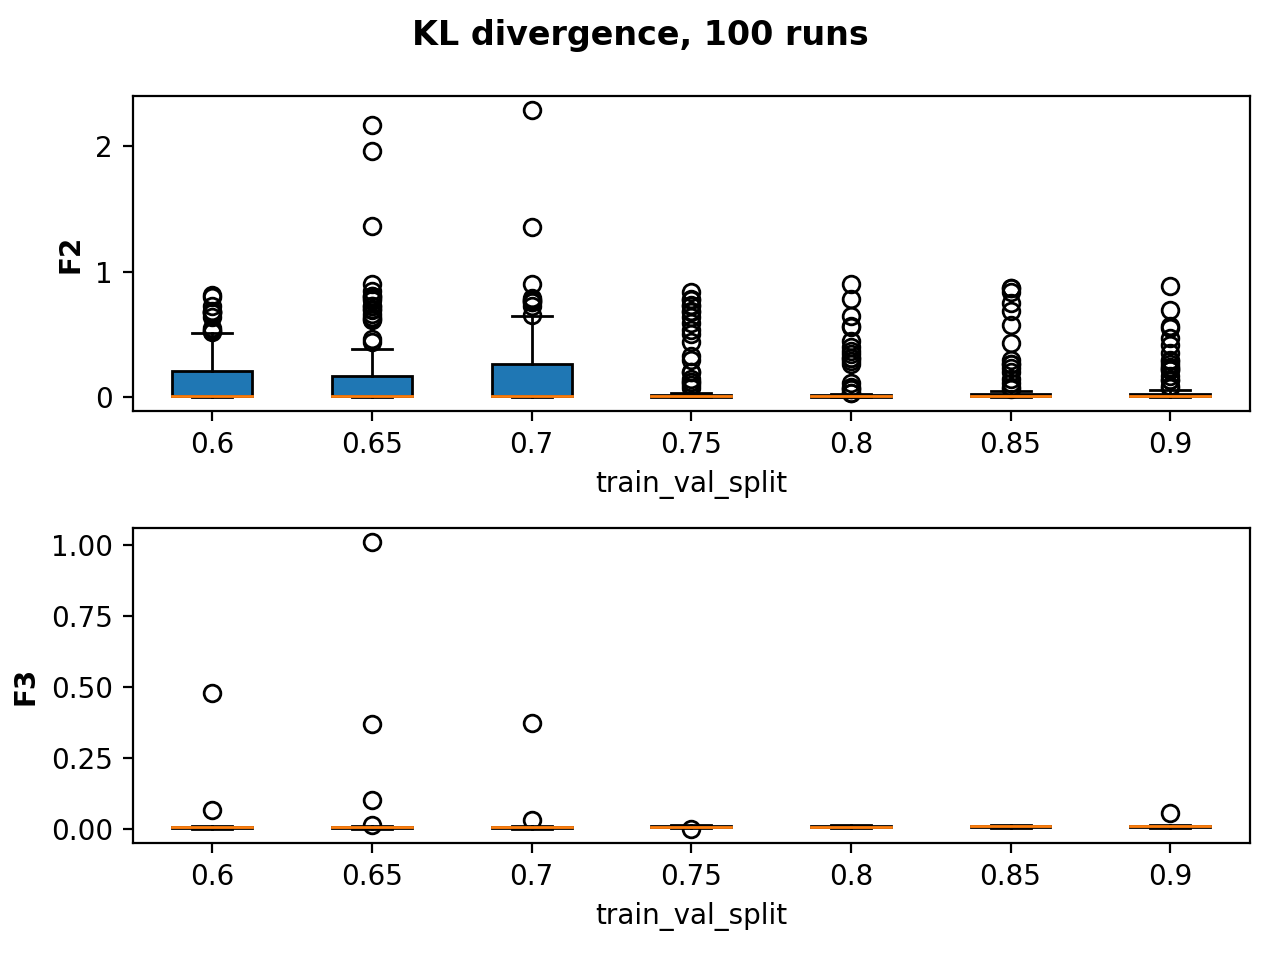

In [24]:
# plot
data = {}
for feature in features_to_predict:
    data[feature] = {}
    for experiment_value in experiment_variable_values:
        data[feature][str(experiment_value)] = [x[str(experiment_value)][feature] for x in output["kl_divergence"].values()]

nr_features = len(features_to_predict)
fig, axs = plt.subplots(nr_features)
fig.suptitle(f"KL divergence, {config['RQ2']['runs']} runs", fontweight='bold')

for nr, feature in enumerate(features_to_predict):
    axs[nr].boxplot(data[feature].values(), patch_artist = True) # , showfliers=False
    axs[nr].set_xticklabels(data[feature].keys())
    axs[nr].set_xlabel(config["general"]["experiment_variable"])
    axs[nr].set_ylabel(feature, fontweight='bold')

plt.tight_layout() 
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "5_kl_divergence.png"), **config["plots"])

### 5.2 Silhouette Score

In [63]:
from sklearn.metrics import silhouette_score

output["silhouette_scores"] = {}
output["silhouette_scores"]["orig_data"] = float(silhouette_score(features, np.ravel(clusters)))

for run in range(config["RQ2"]["runs"]):
    output["silhouette_scores"][f"run_{run}"] = {}
    for i, experiment_value in enumerate(experiment_variable_values):
        if len(np.unique(clusters_reconstr[run][i])) > 1:
            output["silhouette_scores"][f"run_{run}"][str(experiment_value)] = float(silhouette_score(features_reconstr[run][i], clusters_reconstr[run][i]))
        else:
            output["silhouette_scores"][f"run_{run}"][str(experiment_value)] = np.nan

<IPython.core.display.Javascript object>


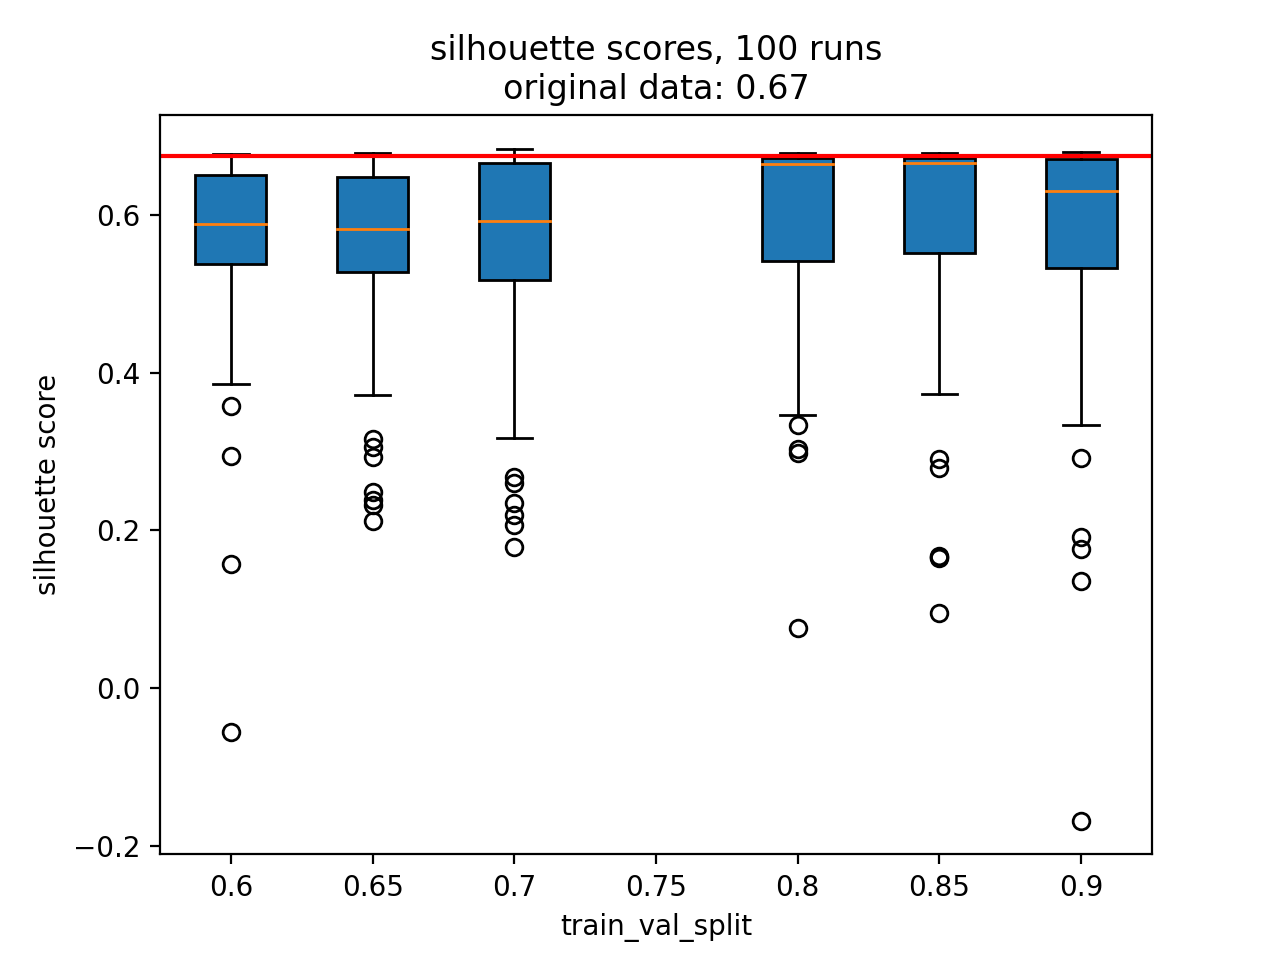

In [65]:
# plot
sil_scores = output["silhouette_scores"].copy()
del(sil_scores["orig_data"])

data = {}
for experiment_value in experiment_variable_values:
    data[str(experiment_value)] = [x[str(experiment_value)] for x in sil_scores.values()]

fig, ax = plt.subplots()
ax.boxplot(data.values(), patch_artist = True)
ax.set_xticklabels(data.keys())
plt.axhline(y=output['silhouette_scores']['orig_data'], color='r', linestyle='-')
plt.xlabel(config["general"]["experiment_variable"])
plt.ylabel("silhouette score")
plt.title(f"silhouette scores, {config['RQ2']['runs']} runs\noriginal data: {round(output['silhouette_scores']['orig_data'], 2)}")
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "5_silhouette_scores.png"), **config["plots"])

### 5.3. Outlierness
#### 5.3.1 Global outliers (considering all features)

In [66]:
# Outliers detected as noise by DBSCAN
output["cluster_noise"] = {}
output["cluster_noise"][f"orig_data"] = sum(clusters_orig == -1)

for run in range(config["RQ2"]["runs"]):
    output["cluster_noise"][f"run_{run}"] = {}
    for i, experiment_value in enumerate(experiment_variable_values):
        output["cluster_noise"][f"run_{run}"][str(experiment_value)] = sum(clusters_reconstr[run][i] == -1)

<IPython.core.display.Javascript object>


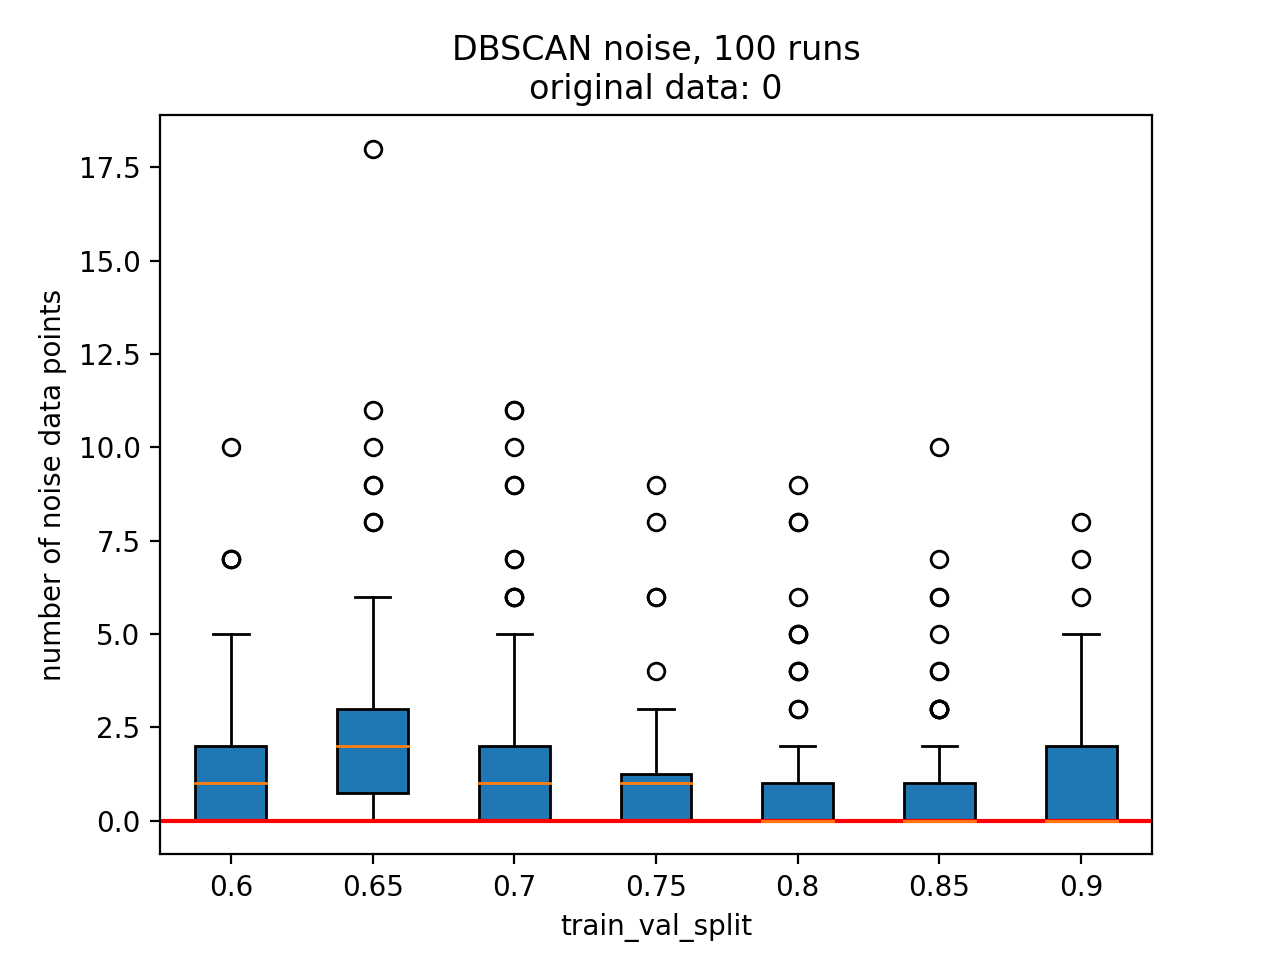

In [67]:
# plot
noise = output["cluster_noise"].copy()
del(noise["orig_data"])

data = {}
for experiment_value in experiment_variable_values:
    data[str(experiment_value)] = [x[str(experiment_value)] for x in noise.values()]

fig, ax = plt.subplots()
ax.boxplot(data.values(), patch_artist = True)
ax.set_xticklabels(data.keys())
plt.axhline(y=output["cluster_noise"]['orig_data'], color='r', linestyle='-')
plt.xlabel(config["general"]["experiment_variable"])
plt.ylabel("number of noise data points")
plt.title(f"DBSCAN noise, {config['RQ2']['runs']} runs\noriginal data: {output['cluster_noise']['orig_data']}")
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "5_DBSCAN-noise.png"), **config["plots"])

### 5.4. Save Output

In [68]:
with open(output_path, "w") as f:
            toml.dump(output, f)